In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
from matplotlib import pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
seed = 1228
np.random.seed(seed)
torch.manual_seed(seed)

batch_size = 512
num_epochs = 500
num_classes = 10  #cGAN
learning_rate = 0.00015

d_noise  = 100
d_hidden = 256
num_noise = 16

GEN_MODEL_PATH = "cGAN_model/Generator.pth"
DIS_MODEL_PATH = "cGAN_model/Discriminator.pth"

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean= 0.5, std=0.5)
])  


train_set = dsets.MNIST(root='data/', train=True, transform=transform, download=True)
test_set  = dsets.MNIST(root='data/', train=False, transform=transform, download=True)


train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_set, batch_size, shuffle=True)

C:\Users\WorkStation\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
def imshow(img):
    img = (img+1)/2    
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

def imshow_grid(img):
    img = utils.make_grid(img.cpu().detach())
    img = (img+1)/2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
def gen_z(num_batch, d_noise):
    return torch.randn(num_batch, d_noise, device=device)
    
def init_params(model):
    for p in model.parameters():
        if(p.dim() > 1):
            nn.init.xavier_normal_(p)
        else:
            nn.init.uniform_(p, 0.1, 0.2)

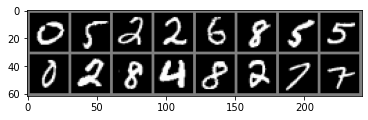

In [5]:
example_mini_batch_img, example_mini_batch_label = next(iter(train_loader))
imshow_grid(example_mini_batch_img[0:num_noise])

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.generator = nn.Sequential(
            nn.Linear(d_noise + num_classes, 128),
            nn.LeakyReLU(0.2),
            
            nn.Linear(128,256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            
            nn.Linear(256,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            
            nn.Linear(512,1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),

            nn.Linear(1024, 1*28*28),
            
            nn.Tanh()
        )
        
    def forward(self, z, y):
        z_given_y = torch.cat((self.label_emb(y), z), -1)
        G_z = self.generator(z_given_y)
        G_z = G_z.view(-1, 1, 28, 28)
        return G_z


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.discriminator = nn.Sequential(
            nn.Linear(num_classes + 28*28, 512),
            nn.LeakyReLU(0.2),
            
            nn.Linear(512,512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2),
            
            nn.Linear(512,512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2),
            
            nn.Linear(512,1),
            
            nn.Sigmoid()
        )
        
    def forward(self, G_z, labels):
        G_z_given_y = torch.cat((G_z.view(G_z.size(0),-1), self.label_emb(labels)), -1)
        D_G_z = self.discriminator(G_z_given_y)
        return D_G_z

generator = Generator()
discriminator = Discriminator()

generator.load_state_dict(torch.load(GEN_MODEL_PATH))
discriminator.load_state_dict(torch.load(DIS_MODEL_PATH))

generator, discriminator = generator.to(device), discriminator.to(device)

***원하는 숫자 생성***

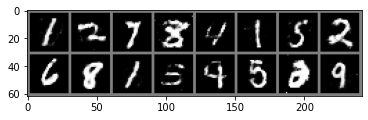

torch.Size([16, 1, 28, 28])


In [7]:
seed = 1228
np.random.seed(seed)
torch.manual_seed(seed)

label = torch.tensor([1, 2, 7, 8, 4, 1, 5, 2, 6, 8, 1, 5, 4, 5, 2, 9]).to(device)
imshow_grid(generator(gen_z(len(label), d_noise), label).view(-1, 1, 28, 28))

print(generator(gen_z(len(label), d_noise), label).view(-1, 1, 28, 28).shape)

***노이즈에 따른 경향성***

torch.Size([80, 1, 28, 28])


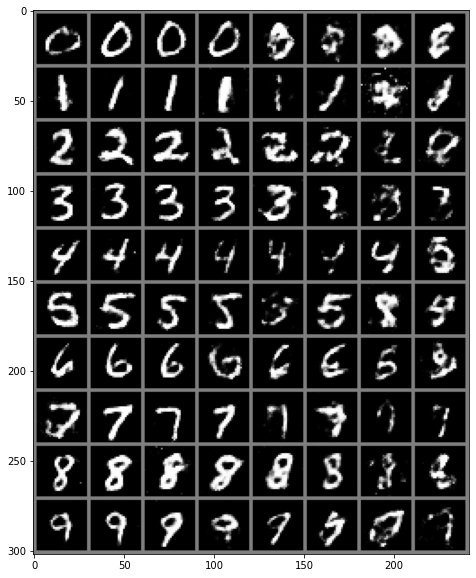

In [21]:
label = torch.tensor([0,1,2,3,4,5,6,7,8,9]).to(device)
a = np.linspace(-1.0, 4.0, 8)

img_list = []


for scale in a:
    img_list.append(generator(scale*gen_z(len(label), d_noise), label).view(-1, 1, 28, 28).tolist())

img_tensor = torch.reshape(torch.transpose(torch.tensor(img_list), 0, 1), (-1, 1, 28,28))

print(img_tensor.shape)
plt.figure(figsize=(10,10))
imshow_grid(img_tensor)